In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, ttest_rel, pearsonr
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [8]:
# Get data on Currency Changes from Yahoo Finance for 5 years
#currency_data = yf.Ticker("EURUSD=X")
#df_currency = currency_data.history(period="5y")

# Export the data to a csv file 
#path = '../Data/eur_usd_exchange_rate.csv'
#df_currency.to_csv(path)

# Read data from csv files
stock_df = pd.read_csv('../Data/loreal_stock_price.csv')
currency_df = pd.read_csv('../Data/eur_usd_exchange_rate.csv')

In [14]:
# Preprocessing data

# Convert to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce', utc = True)
currency_df['Date'] = pd.to_datetime(currency_df['Date'], errors='coerce', utc=True)

# Remove invalid Date
stock_df = stock_df.dropna(subset=['Date'])
currency_df = currency_df.dropna(subset=['Date'])

# Consider only date part
stock_df['Date'] = stock_df['Date'].dt.date
currency_df['Date'] = currency_df['Date'].dt.date

# Merge stock price and currency changes
merged_df = pd.merge(stock_df, currency_df, on='Date', how='inner')
merged_df = merged_df[['Date', 'Close_x', 'Close_y']]
merged_df.columns = ['Date', 'Close_stock', 'Close_currency']
print(merged_df.head())

# ANOVA to determine the correlation between close stock price(dependent) and currency exchange rate(independent)
model = ols('Close_stock ~ C(Close_currency)', data=merged_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)



         Date  Close_stock  Close_currency
0  2019-11-11   240.710312        1.102244
1  2019-11-12   241.446991        1.103546
2  2019-11-13   241.446991        1.101237
3  2019-11-14   240.802383        1.101322
4  2019-11-18   240.157776        1.105510
                         sum_sq      df         F    PR(>F)
C(Close_currency)  4.516436e+06  1093.0  1.456446  0.017268
Residual           2.241343e+05    79.0       NaN       NaN


# Result breakdown

**Sum of Squares:** The SS of Close_currency(about 4,500,000) is much larger than the SS of Residual(about 220,000), which means that the there is a significant portion of the variability in the data, indicating a good fit with relatively small prediction errors.

**F-Stat:** The quite low F value(1.456) suggests that the model's explanatory power is limited. However, it is necessary to consider both F-value and p-value as p-value is crucial for determining statistical significance.

**Significance of the Factor:** The p-value is less than 0.05, suggesting that there is a low probability that the relationship between stock price and currency exchange rate is due to random chance. It gives us confidence to say that the relationship observed in the sample likely exists in the population.

***In conclusion, based on the ANOVA result, we can state that the currency exchange rate have a statistically significant effect on stock price***

# Scatter Plot


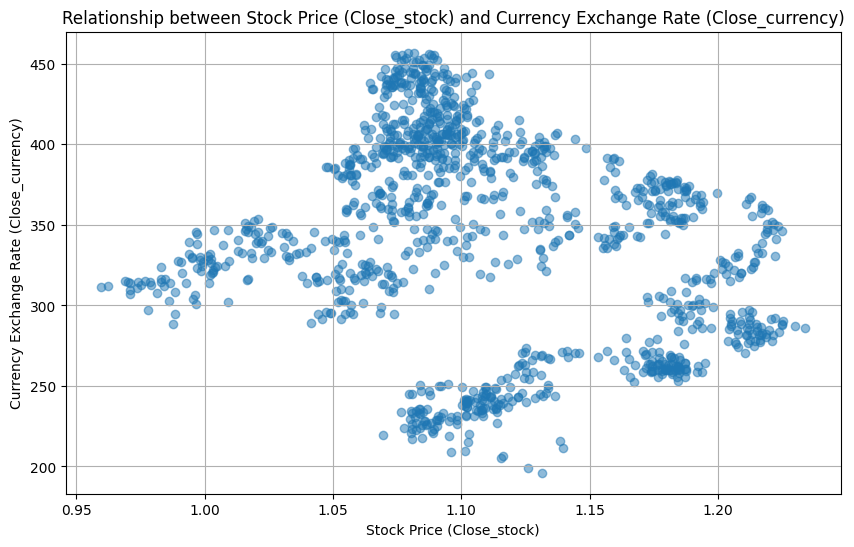

In [10]:
# Plot the relationship between stock price (Close_x) and currency exchange rate (Close_y)
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Close_currency'], merged_df['Close_stock'], alpha=0.5)
plt.title('Relationship between Stock Price (Close_stock) and Currency Exchange Rate (Close_currency)')
plt.xlabel('Stock Price (Close_stock)')
plt.ylabel('Currency Exchange Rate (Close_currency)')
plt.grid(True)
plt.show()




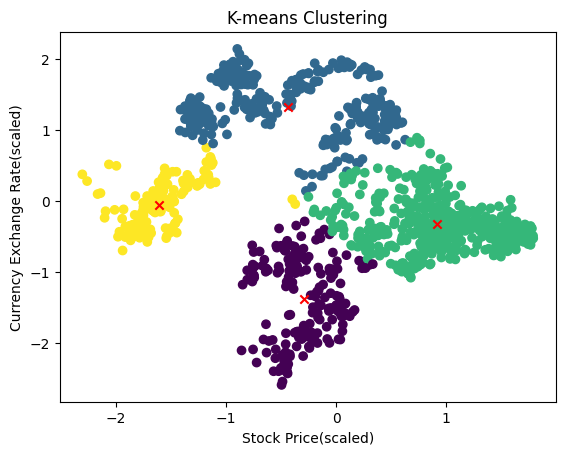

In [11]:
# K-Means

data = merged_df[['Close_stock', 'Close_currency']].values

# Standardize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# KMeans algorithm with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(data_scaled)
labels = kmeans.predict(data_scaled)
centroids = kmeans.cluster_centers_

# Plot k-means clustering
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
plt.xlabel('Stock Price(scaled)')
plt.ylabel('Currency Exchange Rate(scaled)')
plt.title('K-means Clustering')
plt.show()

In [12]:
# Linear regression to predict stock prices

# Convert to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce', utc = True)
currency_df['Date'] = pd.to_datetime(currency_df['Date'], errors='coerce', utc=True)

# Remove invalid Date
stock_df = stock_df.dropna(subset=['Date'])
currency_df = currency_df.dropna(subset=['Date'])

# Consider only date part
stock_df['Date'] = stock_df['Date'].dt.date
currency_df['Date'] = currency_df['Date'].dt.date

# Merge stock price and currency changes
merged_df = pd.merge(stock_df, currency_df, on='Date', how='inner')
merged_df = merged_df[['Date', 'Close_x', 'Close_y']]
merged_df.columns = ['Date', 'Close_stock', 'Close_currency']
print(merged_df.head())

# ANOVA to determine the correlation between close stock price(dependent) and currency exchange rate(independent)
model = ols('Close_stock ~ C(Close_currency)', data=merged_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)# Giả sử file CSV có nhiều cột cho các biến độc lập và một cột cho biến phụ thuộc
# Ví dụ: các cột 'feature1', 'feature2', 'feature3', ..., 'target'
independent = merged_df[['Close_currency', '', 'feature3']].values  # Các biến độc lập
y = data['target'].values                              # Biến phụ thuộc

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Khởi tạo mô hình Linear Regression
model = LinearRegression()

# Huấn luyện mô hình với tập huấn luyện
model.fit(X_train, y_train)

# Dự đoán giá trị của biến phụ thuộc trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán (chỉ vẽ được với một biến độc lập)
plt.scatter(y_test, y_pred, color='blue', label='Dự đoán vs Thực tế')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title('Linear Regression')
plt.legend()
plt.show()


         Date  Close_stock  Close_currency
0  2019-11-11   240.710312        1.102244
1  2019-11-12   241.446991        1.103546
2  2019-11-13   241.446991        1.101237
3  2019-11-14   240.802383        1.101322
4  2019-11-18   240.157776        1.105510
                         sum_sq      df         F    PR(>F)
C(Close_currency)  4.516436e+06  1093.0  1.456446  0.017268
Residual           2.241343e+05    79.0       NaN       NaN


KeyError: "['', 'feature3'] not in index"

In [ ]:
# Nội suy dữ liệu theo quý thành dữ liệu theo ngày bằng phương pháp tuyến tính
quarterly_data_daily = quarterly_data.resample('D').interpolate(method='linear')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Đọc dữ liệu từ file CSV
data = pd.read_csv('your_data_file.csv')

# Giả sử file CSV có các cột: 'date', 'daily_value', 'EPS', 'total_sales'
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Nội suy dữ liệu theo quý thành dữ liệu theo ngày (nếu cần)
# Giả sử EPS và total_sales là dữ liệu theo quý
quarterly_data = data[['EPS', 'total_sales']].resample('D').interpolate(method='linear')

# Kết hợp dữ liệu
combined_data = data.join(quarterly_data, how='outer')

# Loại bỏ các giá trị NaN (nếu có)
combined_data.dropna(inplace=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = combined_data[['daily_value', 'EPS', 'total_sales']].values
y = combined_data['daily_value'].values  # Giả sử 'daily_value' là biến phụ thuộc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Khởi tạo mô hình Linear Regression
model = LinearRegression()

# Huấn luyện mô hình với tập huấn luyện
model.fit(X_train, y_train)

# Dự đoán giá trị của biến phụ thuộc trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.scatter(y_test, y_pred, color='blue', label='Dự đoán vs Thực tế')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title('Linear Regression')
plt.legend()
plt.show()
